In [1]:
# %load train_srgan.py
# hickle版本 ：hickle==3.4.9
import torch.backends.cudnn as cudnn
import torch
# from torchsummary import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torch.autograd as autograd
from models import Generator
from models import Discriminator
from xxydataset import xxyDataset
import utils
import xlwt
import xlrd
from xlutils.copy import copy
import time
import os
import IPython.display as display
import matplotlib.pyplot as plt
# import imageio
from PIL import Image

In [2]:
# 设定使用的GPU的编号
torch.cuda.set_device(2)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

global checkpoint, start_epoch
# 生成器模型参数
kernel_size_g = 3         # 卷积核大小
n_channels_g = 64         # 通道数
n_blocks_g = 5            # 残差模块数量

# 鉴别器模型参数
kernel_size_d = 3  # 卷积核大小
n_channels_d = 64  # 模块的通道数

# 学习参数
batch_size = 128     # 批大小
start_epoch = 1     # 迭代起始位置
epochs = 30000         # 迭代轮数
checkpoint = None   # 若从断点开始训练，填写相对路径，如"./result_gan/checkpoint_epoch540.pth"
workers = 1         # 加载数据线程数量
lr = 1e-4           # 学习率
lr_adj_1 = 0.1        # 学习率调整乘子
lr_adj_2 = 0.5        # 学习率调整乘子
g_adversarial_ratio = 1  #各项损失函数权重，自行调整
tv_loss_ratio = 0
mse_loss_ratio = 0


# 设备参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True    # 对卷积进行加速

# 模型初始化
generator = Generator(kernel_size=kernel_size_g,
                      n_channels=n_channels_g,
                      n_blocks=n_blocks_g)
discriminator = Discriminator(kernel_size=kernel_size_d,
                              n_channels=n_channels_d)


In [3]:
# 初始化优化器
optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()), lr=lr)
optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()), lr=lr)

# 损失函数
tv_loss_criterion = utils.TVLoss()
mse_loss_criterion = nn.MSELoss()
adversarial_loss_criterion = nn.BCEWithLogitsLoss()
g_adversarial_loss_criterion = nn.BCEWithLogitsLoss()  # Generator
d_adversarial_loss_criterion = nn.BCEWithLogitsLoss()   # Discriminator

# 将数据移至默认设备
generator = generator.to(device)
discriminator = discriminator.to(device)
mse_loss_criterion = mse_loss_criterion.to(device)
tv_loss_criterion = tv_loss_criterion.to(device)
adversarial_loss_criterion = adversarial_loss_criterion.to(device)
g_adversarial_loss_criterion = g_adversarial_loss_criterion.to(device)
d_adversarial_loss_criterion = d_adversarial_loss_criterion.to(device)

In [4]:
# 加载断点
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d'])

# 加载数据集
train_dataset = xxyDataset()
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=workers,
                                           pin_memory=True)

dataset loaded : 30082*1*40*40


In [5]:
# LR_TO_SHOW，用来产生gif的低分辨率图像
# x = 10 # 要生成的gif数数
# for i, (LR_TO_SHOW, HR_TO_SHOW) in enumerate(train_loader):
# # (LR_TO_SHOW, HR_TO_SHOW) = train_loader[0]
#     if i == 0:
#         LR_TO_SHOW = LR_TO_SHOW[0:x]
#         HR_TO_SHOW = HR_TO_SHOW[0:x]
#         break

# for i in range(len(HR_TO_SHOW)):
#     hr_to_show = HR_TO_SHOW[i]
#     hr_to_show = hr_to_show.numpy()
#     hr_to_show = 127.5 * hr_to_show + 127.5
#     hr_to_show = hr_to_show.squeeze()
#     pic_name = './gifs/hr_' + str(i) + '.png'
#     imageio.imsave(pic_name, hr_to_show)
    
#     lr_to_show = LR_TO_SHOW[i]
#     lr_to_show = lr_to_show.numpy()
#     lr_to_show = 127.5 * lr_to_show + 127.5
#     lr_to_show = lr_to_show.squeeze()
#     pic_name = './gifs/lr_' + str(i) + '.png'
#     imageio.imsave(pic_name, lr_to_show)

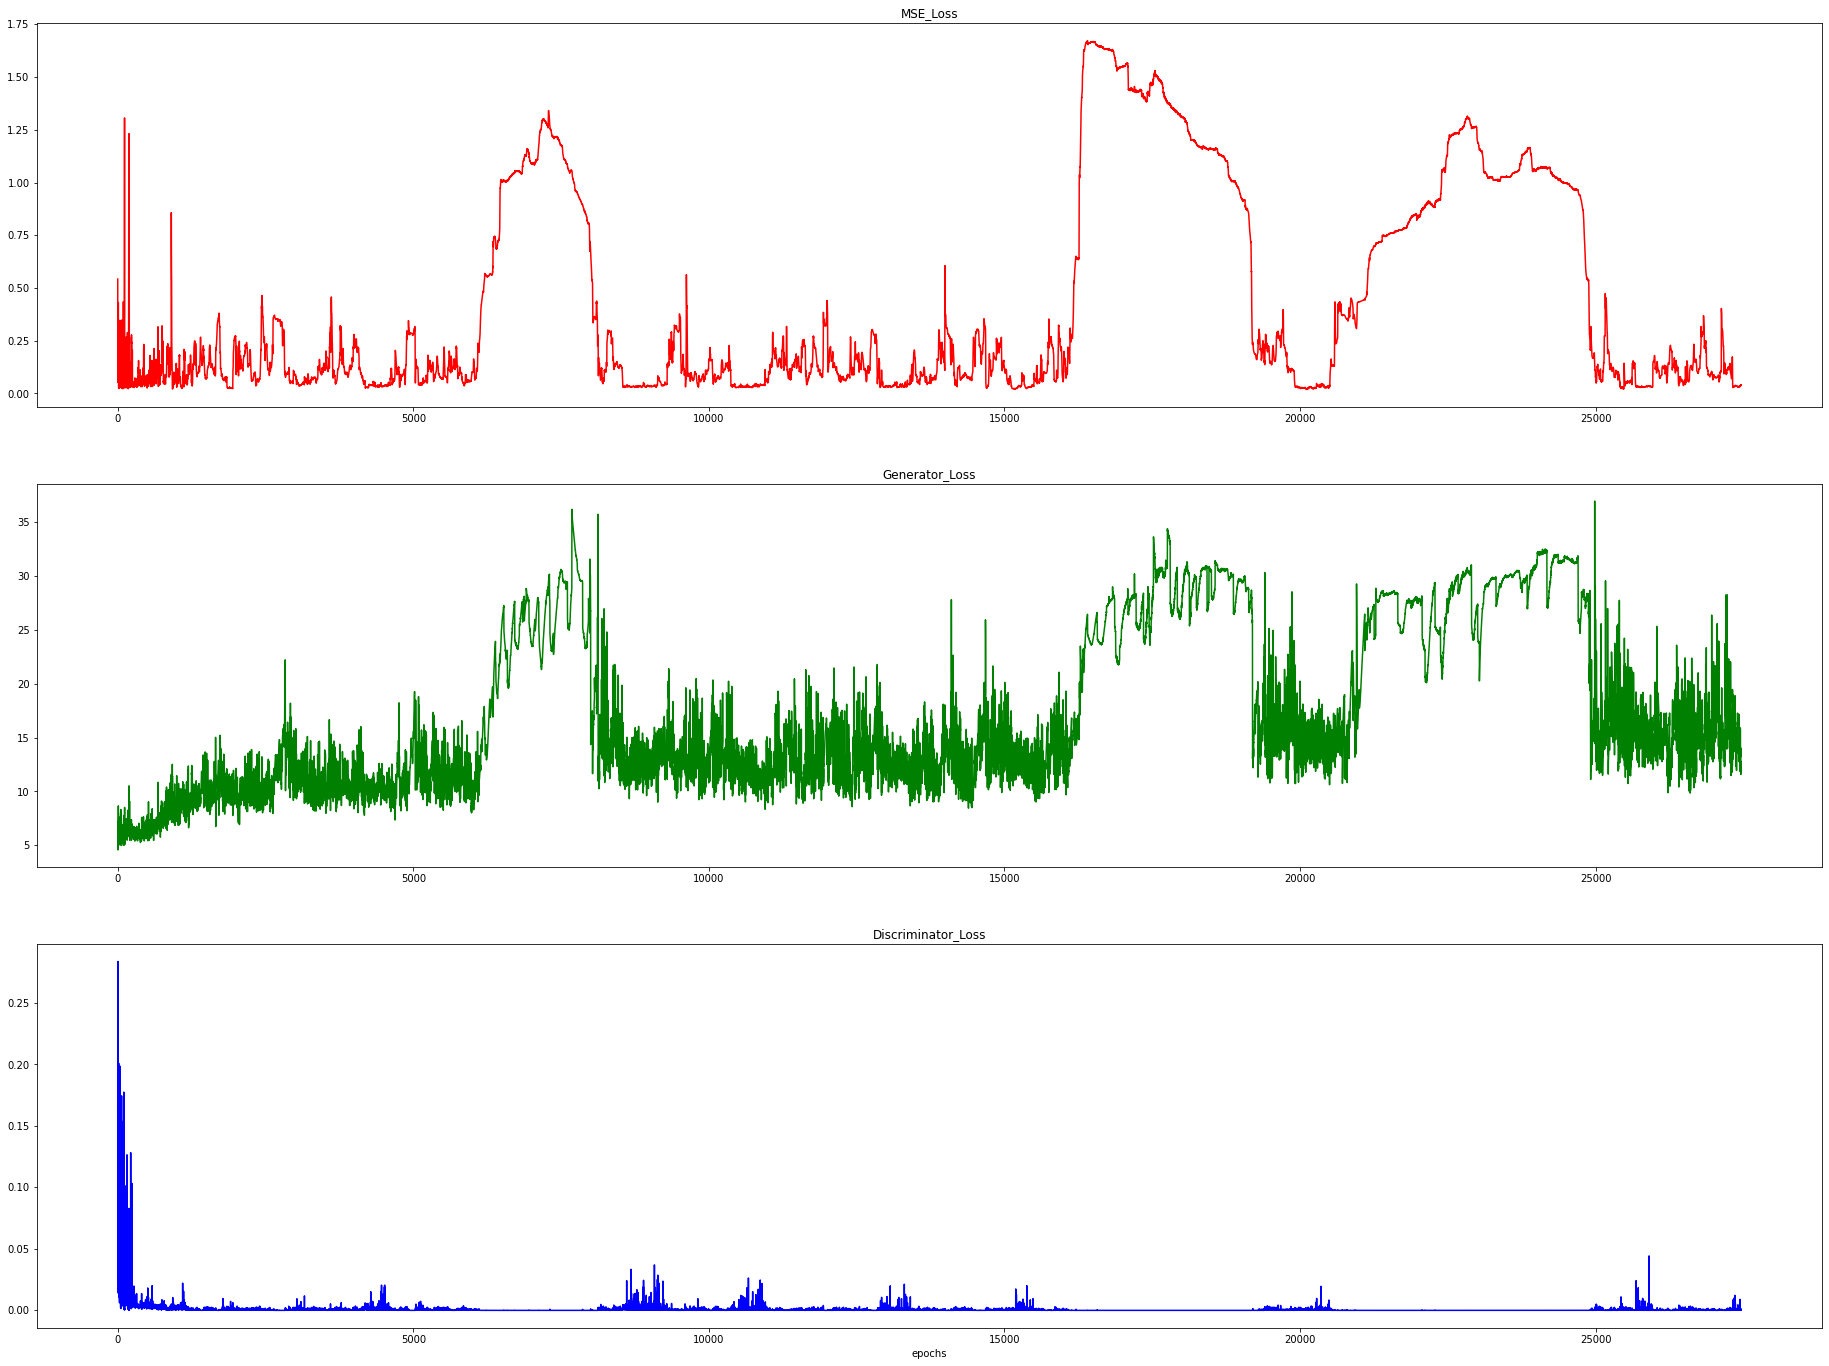

目前最好结果 ：第 20108 个epoch   Best_MSE = 0.019227819263634906
第 27460 个epoch结束总用时  9.773 秒 average mse = 0.04042555988166816
第 27461 个epoch结束总用时  9.752 秒 average mse = 0.038494323253171904
第 27462 个epoch结束总用时  9.765 秒 average mse = 0.037034976809125146
第 27463 个epoch结束总用时  9.746 秒 average mse = 0.038250866634169996
第 27464 个epoch结束总用时  9.757 秒 average mse = 0.036471906817097687
第 27465 个epoch结束总用时  9.897 秒 average mse = 0.03439008552930542
第 27466 个epoch结束总用时  9.832 秒 average mse = 0.033944346914701294
第 27467 个epoch结束总用时  9.743 秒 average mse = 0.03390250270547848
第 27468 个epoch结束总用时  9.759 秒 average mse = 0.03407503639924131
第 27469 个epoch结束总用时  9.768 秒 average mse = 0.03421776996025543


KeyboardInterrupt: 

In [6]:
# +
# 开始逐轮训练
standard_MSE = 0.025
best_MSE = 0.025
best_epoch = -1
print("***开始训练***")
for epoch in range(start_epoch, epochs+1):
    if epoch == 250:  # 执行到250轮时降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_1)
        utils.adjust_learning_rate(optimizer_d, lr_adj_1)
    if epoch == 1200:  # 执行到1200轮时降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_2)
        utils.adjust_learning_rate(optimizer_d, lr_adj_2)

     # -----------------------生成器产生并保存图片----------------------------
#     with torch.no_grad():
#         LR_TO_SHOW = LR_TO_SHOW.type(torch.FloatTensor)
#         LR_TO_SHOW = LR_TO_SHOW.to(device)
#         sr_to_show = generator(LR_TO_SHOW)
#         sr_to_show = sr_to_show.cpu().numpy()
#         for i,sr in enumerate(sr_to_show):
#             sr = sr.squeeze()
#             sr = 127.5 * sr + 127.5
#             pic_name = './gifs/sr_' + str(i) + '_epoch_' + str(epoch-1).zfill(3) + '.png'
#             imageio.imsave(pic_name, sr)


#     with torch.no_grad():
#         for i in range(len(LR_TO_SHOW)):
#             lr_to_show = LR_TO_SHOW[i].unsqueeze(0)
#             print(lr_to_show.shape)
#             lr_to_show = torch.Tensor(lr_to_show)
#             lr_to_show = lr_to_show.type(torch.FloatTensor)
#             lr_to_show = lr_to_show.to(device)
#             sr_to_show = generator(lr_to_show)
#             sr_to_show = sr_to_show.numpy()
#             sr_to_show = 127.5 * sr_to_show + 127.5
#             pic_name = './gifs/sr_' + str(i) + '_epoch_' + str(epoch).zfill(3) + '.png'
#             imageio.imsave(pic_name, sr_to_show)
    
    generator.train()   # 开启训练模式：允许使用批样本归一化
    discriminator.train()

    losses_c = utils.AverageMeter()  # 内容损失
    losses_a = utils.AverageMeter()  # 生成损失
    losses_d = utils.AverageMeter()  # 判别损失

    start_time = time.time()
    for batch, (lr_imgs, hr_imgs, distance, chrom) in enumerate(train_loader):
        lr_imgs = lr_imgs.type(torch.FloatTensor)
        hr_imgs = hr_imgs.type(torch.FloatTensor)
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
            
        # -----------------------1. 生成器更新----------------------------
        sr_imgs = generator(lr_imgs)
        sr_discriminated = discriminator(sr_imgs)
        # tv_loss = tv_loss_criterion(sr_imgs)
        mse_loss = mse_loss_criterion(sr_imgs, hr_imgs)
        # 生成器希望生成的图像能够完全迷惑判别器，因此它的预期所有图片真值为1
        g_adversarial_loss = g_adversarial_loss_criterion(sr_discriminated, 
                                                          torch.ones_like(sr_discriminated))
        g_loss = g_adversarial_ratio*g_adversarial_loss + tv_loss_ratio*tv_loss + mse_loss_ratio*mse_loss

        # 后向传播
        optimizer_g.zero_grad()
        g_loss.backward()

        # 更新生成器参数
        optimizer_g.step()

        # 记录损失值
        losses_c.update(mse_loss.item(), lr_imgs.size(0))
        losses_a.update(g_loss.item(), lr_imgs.size(0))

        # -----------------------2. 判别器更新----------------------------
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())

        d_loss1 = d_adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) 
        d_loss2 = d_adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))  
        d_loss = d_loss1 + d_loss2
        
        # 后向传播
        optimizer_d.zero_grad()
        d_loss.backward()

        # 更新判别器
        optimizer_d.step()
        losses_d.update(d_loss.item(), hr_imgs.size(0))
    end_time = time.time()

    if losses_c.avg < standard_MSE:
        save_path = './result_gan/best_checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        if os.path.exists(save_path):
            os.remove(save_path)
        if losses_c.avg < best_MSE:
            best_epoch = epoch
            best_MSE = losses_c.avg
            save_path = './result_gan/best_checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)

    if epoch % 20 == 0:
        save_path = './result_gan/checkpoint_epoch' + str(epoch).zfill(3) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
        display.clear_output(wait=True)
        
        # 各项损失随epoch的收敛曲线
        rb = xlrd.open_workbook(r'./log_gan.xls')
        ws = rb.sheet_by_index(0)
        x_epochs  = [float(ws.cell_value(i, 0)) for i in range(1, epoch)]
        mse       = [float(ws.cell_value(i, 1)) for i in range(1, epoch)]
        loss_a    = [float(ws.cell_value(i, 2)) for i in range(1, epoch)]
        loss_d    = [float(ws.cell_value(i, 3)) for i in range(1, epoch)]
        
#         mpl.rcParams['font.sans-serif'] = 'SimHei' #不设置的话，使用matplotlib画出的图中的汉字会是乱码
#         mpl.rcParams['axes.unicode_minus'] = False
        plt.figure(figsize=(32, 24))
    
        plt.subplot(3,1,1)
        plt.title("MSE_Loss")
        plt.plot(x_epochs, mse   , color = 'r',label="mse")
        
        plt.subplot(3,1,2)
        plt.title("Generator_Loss")
        plt.plot(x_epochs, loss_a, color = 'g',label="loss_generator")
        
        plt.subplot(3,1,3)
        plt.title("Discriminator_Loss")
        plt.plot(x_epochs, loss_d, color = 'b',label="loss_discriminator")
        plt.xlabel("epochs")
        #plt.legend(loc = "best")
        plt.show()
        print("目前最好结果 ：第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
        
#         # 展示gif的代码
#         for i in range(len(LR_TO_SHOW)):
# #             pic_list = []
# #             for j in range(epoch):
# #                 pic_list.append('./gifs/sr_' + str(i) + '_epoch_' + str(j).zfill(3) + '.png')
            
#             gif_name = './gifs/gif/sr_' + str(i) + '.gif'
#             images = []
#             for j in range(epoch):
#                 images.append(imageio.imread('./gifs/sr_' + str(i) + '_epoch_' + str(j).zfill(3) + '.png'))
#             imageio.mimwrite(gif_name, images, 'GIF', duration=0.1)

    print("第 " + str(epoch) + " 个epoch结束" + '总用时  {:.3f} 秒'.format(end_time-start_time) + ' average mse = ' + str(losses_c.avg))
    time_cost = format(end_time-start_time)  # 计算用时
    rb = xlrd.open_workbook(r'./log_gan.xls')
    wb = copy(rb)
    ws = wb.get_sheet(0)
    ws.write(epoch, 0, epoch)
    ws.write(epoch, 1, losses_c.avg)
    ws.write(epoch, 2, losses_a.avg)
    ws.write(epoch, 3, losses_d.avg)
    ws.write(epoch, 4, time_cost)
    wb.save('./log_gan.xls')

print("第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
# -